# Simulating Shear-Induced Chaos

In [18]:
#Import packaqes
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
%matplotlib inline

# (1) Sample code

<ipython-input-2-6e566b4d767a>:18: RuntimeWarning: divide by zero encountered in log
  result.append(np.log(abs(1 - 2*x)))


Text(0.5, 1.0, 'Map of x(t+1) = x(t) + r - x(t)^2 versus Lyapunov exponent')

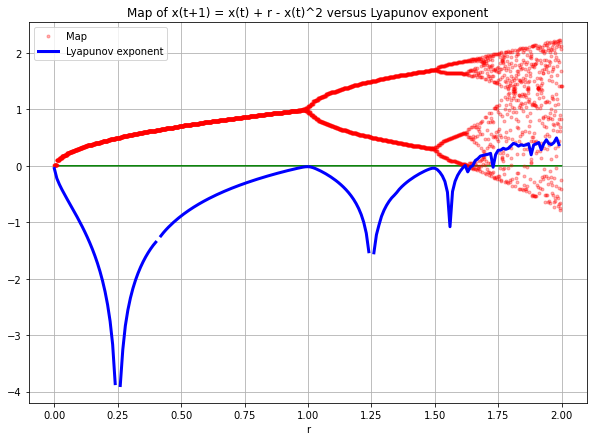

In [2]:
#This is some code stolen from http://systems-sciences.uni-graz.at/etextbook/sw2/lyapunov.html

result = []
lambdas = []
maps = []

# define range of r 
rvalues = np.arange(0, 2, 0.01)

# loop through r
for r in rvalues:
    x = 0.1
    result = []
    # iterate system 100 times
    for t in range(100):
        x = x + r - x**2
        # calculate log of the absolute of the derivative
        result.append(np.log(abs(1 - 2*x)))
    # take average
    lambdas.append(np.mean(result))
    # for the map ignore first 100 iterations as transient time and iterate anew
    for t in range(20):
        x = x + r - x**2
        maps.append(x)    
    
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(1,1,1)

xticks = np.linspace(0, 2, 4000)
# zero line
zero = [0]*4000
ax1.plot(xticks, zero, 'g-')
# plot map
ax1.plot(xticks, maps, 'r.',alpha = 0.3, label = 'Map')
ax1.set_xlabel('r')
# plot lyapunov
ax1.plot(rvalues, lambdas, 'b-', linewidth = 3, label = 'Lyapunov exponent')
ax1.grid('on')
ax1.set_xlabel('r')
ax1.legend(loc='best')
ax1.set_title('Map of x(t+1) = x(t) + r - x(t)^2 versus Lyapunov exponent')

# (2) Simulate System Trajectories

<ipython-input-93-2642a155422a>:35: RuntimeWarning: invalid value encountered in log
  y_list.append(1/((i+1)*dt) * np.log(y[i+1]/y_0))


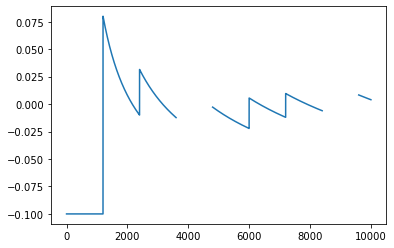

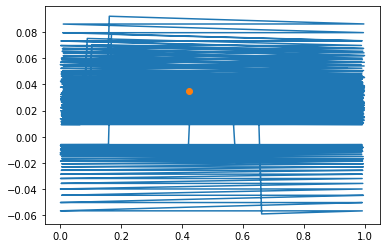

[0.42353286 0.43458864 0.44564336 ... 0.91884206 0.93041669 0.94198975]


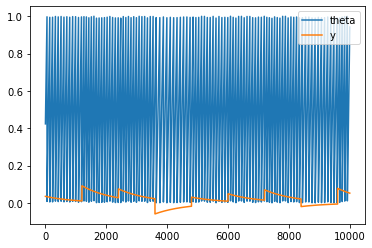

In [93]:
def H(theta):
    return np.sin(2*np.pi*theta)

#random initialziation
theta_0 = np.random.uniform(0,1)
y_0 = np.random.uniform(-0.1, 0.1)

#pick parameters
sigma = 3 #shear
lam = 0.1 #damping
A = 0.1 #kick amplitude
T = 12 #time interval of kicks
dt = 0.01 #time step size
n_steps = 10000 #number of timesteps

theta = np.zeros(n_steps+1)
y = np.zeros(n_steps+1)
theta[0] = theta_0
y[0] = y_0

theta_list = []
y_list = []


#doing Euler's method for study 1
for i in range(n_steps):
    theta[i+1] = (theta[i] + (1 + sigma*y[i])*dt) % 1 #need the mod because we say inside [0,1]
    
    if (i+1)*dt % T == 0: #if you have kick
        y[i+1] = y[i] + (-lam*y[i])*dt + A*H(theta[i])
    else: #no kick
        y[i+1] = y[i] + (-lam*y[i])*dt
        
    theta_list.append(1/((i+1)*dt) * np.log(theta[i+1]/theta_0))
    y_list.append(1/((i+1)*dt) * np.log(y[i+1]/y_0))
    
# plt.plot(theta_list)
plt.plot(y_list)
plt.show()
    
#plotting a few things to see what's going on
plt.plot(theta, y)
plt.plot(theta_0, y_0, "o", linewidth = 4)
plt.show()

plt.figure()
plt.plot(theta, label = "theta")
plt.plot(y, label = "y")
plt.legend()
print(theta)

# (3) Map reduction and jacobian computation

In [95]:
# Build Map reduction of dynamics
def f_map(theta,y,lam, sigma, T, A): # for theta
    return (theta + T + (sigma/lam)*(y + A*H(theta))*(1 - np.exp(-lam*T))) % 1

def g_map(theta, y, lam, T, A): # for y
    return np.exp(-lam*T)*(y + A*H(theta))

# Compute Jacobian
def jac1(theta, sigma ,lam, T, A):
    c1 = np.exp(-lam*T)
    c2 = sigma/lam
    c3 = 2*np.pi*A*np.cos(2*np.pi*theta)
    
    j11, j12 = (1 + c2*c3*(1-c1)), (c2*(1-c1))
    j21, j22 = (c1*c3), c1
    
    return np.array([[j11, j12],[j21, j22]])

# Run test simulations
ly_s = []
max_iter = 400000

for i in tqdm.trange(10):
    
    # random initialization
    theta_T = np.random.uniform(0,1)
    y_T = np.random.uniform(-0.1, 0.1)
    
    # generate unit tangent vector
    u = np.array([[0,1],[1,0]]) # tangent vectors (?)
    J_prod = u # log argument for lyapunov exponent
    
    u_s = []
    
    for i in range(max_iter):
        
        J_prod = jac1(theta_T, sigma, lam, T, A).dot(J_prod)
        J_prod[0,:] = J_prod[0,:] %1
        u_s.append([np.linalg.norm(J_prod[:,0]),np.linalg.norm(J_prod[:,1])])
        
        theta_T = f_map(theta_T, y_T, lam, sigma, T, A)
        y_T = g_map(theta_T, y_T, lam, T, A)

        #eig_T,_ = np.linalg.eig(jac1(theta_T, sigma, lam, T, A)) 
        #eig_s.append(np.max(np.abs(np.real(eig_T))).item())
        
    ly_exp = np.log([np.linalg.norm(J_prod[:,0]),np.linalg.norm(J_prod[:,1])])/(T*max_iter)
    ly_s.append(ly_exp)
    
    # Plot tangent vector norm
    u_s = np.vstack(u_s)
    if i == 7:
        plt.figure()
        plt.plot(u_s[-100:,0])
        plt.plot(u_s[-100:,1])
        plt.show()

print(np.vstack(ly_s))

100%|██████████| 10/10 [08:07<00:00, 48.73s/it]

[[-3.81889851e-07 -3.09230966e-07]
 [-6.88640006e-07 -1.30395532e-07]
 [-1.57747281e-07 -1.57504061e-07]
 [-2.48117292e-07 -2.82648882e-07]
 [-1.27684858e-08 -5.95671488e-07]
 [-9.25559344e-08 -7.48602481e-08]
 [-2.96882618e-07 -6.21690219e-08]
 [-8.10165041e-08 -3.73825285e-08]
 [-3.10231178e-07 -1.63093902e-07]
 [-8.43655762e-08 -9.58198767e-08]]


# (4) Runge-Kutta Method

In [ ]:
def f(y, sigma):
    return 1 + sigma * y

def g(theta, y, lam, t, T, A):
    if (t % T == 0):#if kick
        return -lam*y + A*H(theta)
    return -lam*y #if not kicked

def RK4(theta, y, dt, lam, t, T, A, sigma):
    K1_theta = f(y, sigma)
    K1_y = g(theta, y, lam, t, T, A)
    
    K2_theta = f(y+dt*K1_y/2, sigma)
    K2_y = g(x+dt*K1_theta/2,y+dt*K1_y/2, lam, t + dt/2, T, A)
    
    K3_theta = f(y+dt*K2_y/2, sigma)
    K3_y = g(x+dt*K2_theta/2,y+dt*K2_y/2, lam, t+dt/2, T, A)
    
    K4_theta = f(y+dt*K3_y, sigma)
    K4_y = g(x+dt*K3_theta, y + dt*K3_y, lam, t + dt, T,A)
    
    K_theta = (K1_theta + 2*K2_theta + 2* K3_theta + K4_theta)/6.0
    K_y = (K1_y + 2*K2_y + 2* K3_y + K4_y)/6.0

    return (K_theta, K_y)


theta_RK = np.zeros(n_steps+1)
y_RK = np.zeros(n_steps+1)
theta_RK[0] = theta_0
y_RK[0] = y_0



#doing Euler's method for study 1
for i in range(n_steps):
    (K_theta, K_y) = RK4(theta[i], y[i], dt, lam, i*dt, T, A, sigma)
    theta_RK[i+1] = (theta[i] + K_theta * dt) % 1 #need the mod because we say inside [0,1]
    y_RK[i + 1] = y[i] + K_y * dt
        
#plotting a few things to see what's going on
plt.plot(theta_RK, y_RK)
# plt.plot(theta, y)
plt.plot(theta_0, y_0, "o", linewidth = 4)
plt.show()

plt.figure()
plt.plot(theta_RK, label = "theta")
plt.plot(y_RK, label = "y")
plt.legend()
print(theta)
plt.show()

plt.title("Differences in 2 methods")
plt.plot(y_RK - y)
plt.plot(theta_RK - theta)

In [ ]:
def d(f, g, ,i,j):
    return np.norm(series[i]-series[j])

f = 
for i in range(N):
    for j in range(i+1,N):
        if d(series,i,j) < eps:
            n+=1
            print n
            for k in range(min(N-i,N-j)):
                dlist[k].append(log(d(series,i+k,j+k)))